In [78]:
import pandas as pd
df = pd.read_csv('data/OBY01CRGEN.csv')
df
# uncomment with cmd + k + u

,Ukazatel,IndicatorType,Roky,CasR2A,Území,Uz0,Hodnota
0,Úhrnná plodnost,5405W,2023,2023,Česko,CZ,1.452572
1,Úhrnná plodnost,5405W,2022,2022,Česko,CZ,1.617747
2,Úhrnná plodnost,5405W,2021,2021,Česko,CZ,1.826536
3,Úhrnná plodnost,5405W,2020,2020,Česko,CZ,1.707373
4,Úhrnná plodnost,5405W,2019,2019,Česko,CZ,1.708963
...,...,...,...,...,...,...,...
1156,Průměrný věk žen při prvním sňatku,7182Z,1965,1965,Česko,CZ,21.700006
1157,Průměrný věk žen při prvním sňatku,7182Z,1964,1964,Česko,CZ,21.534990
1158,Průměrný věk žen při prvním sňatku,7182Z,1963,1963,Česko,CZ,21.342171
1159,Průměrný věk žen při prvním sňatku,7182Z,1962,1962,Česko,CZ,21.359491


In [79]:
# Keep only what you want (drops the rest)
df = df[["Roky", "Ukazatel", "Hodnota"]].copy()
target_variable = 'Čistá míra reprodukce'

Section 0: The Universal Gatekeeper (Splitter)

In [67]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

class DataSplitter:
    """
    Ultimate ML Pipeline: Section 0 - The Gatekeeper.
    Splits data immediately to ensure the Test set remains 
    pure and unseen by ANY downstream processes (EDA, Scaling, etc.).
    """
    def __init__(self, df, target_col, time_col=None):
        self.df = df.copy()
        self.target_col = target_col
        self.time_col = time_col
        self.train = None
        self.test = None

    def split_data(self, test_size=0.2):
        """
        Splits the dataframe.
        - If time_col is present: Sorts by time and cuts the last 20%.
        - If no time_col: Randomly shuffles and splits.
        """
        if self.time_col:
            # Temporal Split (No Shuffling)
            print(f"⏳ Temporal Mode: Sorting by '{self.time_col}' and splitting...")
            self.df = self.df.sort_values(by=self.time_col)
            
            split_idx = int(len(self.df) * (1 - test_size))
            self.train = self.df.iloc[:split_idx].copy()
            self.test = self.df.iloc[split_idx:].copy()
            
            # Verify the timeline
            train_end = self.train[self.time_col].max()
            test_start = self.test[self.time_col].min()
            print(f"   Train Range: ... to {train_end}")
            print(f"   Test Range:  {test_start} to ...")
            
        else:
            # Random Split
            print("🎲 Standard Mode: Randomly shuffling and splitting...")
            self.train, self.test = train_test_split(
                self.df, test_size=test_size, random_state=42, shuffle=True
            )
            
        print(f"✅ Split Complete: {len(self.train)} Train rows, {len(self.test)} Test rows.")
        return self.train, self.test

# --- Usage Example (At the very start of script) ---
splitter = DataSplitter(df, target_col=target_variable, time_col='Roky')
df, test_df = splitter.split_data(test_size=0.2)

⏳ Temporal Mode: Sorting by 'Roky' and splitting...
   Train Range: ... to 2002
   Test Range:  2003 to ...
✅ Split Complete: 83 Train rows, 21 Test rows.


In [37]:
# Custom transformation to wide format
df_wide = (
    df
    .pivot_table(
        index="Roky",
        columns="Ukazatel",
        values="Hodnota",
        aggfunc="mean"   # safe even if duplicates appear later
    )
    .reset_index()
    .sort_values("Roky")
)

# optional: ensure numeric dtype
for col in df_wide.columns:
    if col != "Roky":
        df_wide[col] = pd.to_numeric(df_wide[col], errors="coerce")

df_wide.to_csv('data/OBY01CRGEN_transformed.csv', index=False, encoding='utf-8-sig')
df = df_wide

In [68]:
import pandas as pd
import numpy as np
import altair as alt

class DataIntake:
    """
    Ultimate ML Pipeline: Section 1.3 - The Nuclear Intake
    Forces data types and uncovers hidden 'String' nulls.
    """
    def __init__(self, df):
        self.df = df.copy()
        self.report = {}

    def _force_discovery(self):
        """
        Attempts to convert every column to numeric. 
        If a cell contains 'Missing value' or text, it becomes np.nan.
        """
        for col in self.df.columns:
            # Skip columns that are clearly intended to be categorical/text
            if self.df[col].dtype == 'object' or self.df[col].dtype == 'string':
                # Attempt conversion; text that can't be a number becomes NaN
                converted = pd.to_numeric(self.df[col], errors='coerce')
                
                # Only update the column if it successfully found numbers
                # (This prevents turning a 'City' name column into all NaNs)
                if converted.notnull().sum() > 0:
                    self.df[col] = converted

    def profile_data(self):
        # 1. Run the discovery first
        self._force_discovery()
        
        # 2. Count actual NaNs now that they are coerced
        null_counts = self.df.isnull().sum().reset_index()
        null_counts.columns = ['column', 'missing_count']
        null_counts['missing_pct'] = (null_counts['missing_count'] / len(self.df)) * 100
        
        # 3. Dynamic Type Tagging
        types = []
        for col in self.df.columns:
            if pd.api.types.is_numeric_dtype(self.df[col]):
                types.append("Continuous Numerical")
            else:
                types.append("Categorical/Text")
        
        null_counts['semantic_type'] = types
        self.report = null_counts
        return self.report

    def plot_dna(self):
        # We add a small baseline (0.5) so you can see a tiny bar 
        # even if the data is 0% missing, ensuring the X-axis labels appear.
        chart = alt.Chart(self.report).mark_bar(size=20).encode(
            x=alt.X('column:N', sort='-y', title="Feature Names (Czech)"),
            y=alt.Y('missing_pct:Q', title="Missing Data (%)", scale=alt.Scale(domain=[0, 100])),
            color=alt.condition(
                alt.datum.missing_pct > 0,
                alt.value('#FF3366'),  # Neon Pink for missing
                alt.value('#00CC96')   # Green for clean
            ),
            tooltip=['column', 'missing_pct']
        ).properties(width=800, height=400, title="Data DNA: Corrected Null Detection")
        
        return chart


# --- Usage Example --- 
intake = DataIntake(df)
profile = intake.profile_data()
print(profile)
intake.plot_dna().display()


                                          column  missing_count  missing_pct  \
0                                           Roky              0     0.000000   
1                          Hrubá míra reprodukce              0     0.000000   
2                             Naděje dožití mužů              0     0.000000   
3                              Naděje dožití žen              0     0.000000   
4   Průměrná délka trvání manželství při rozvodu             11    13.253012   
5      Průměrný věk matek při narození 1. dítěte              5     6.024096   
6         Průměrný věk matek při narození dítěte              0     0.000000   
7            Průměrný věk mužů při prvním sňatku             41    49.397590   
8             Průměrný věk žen při prvním sňatku             41    49.397590   
9              Tabulková prvosňatečnost mužů (%)             41    49.397590   
10              Tabulková prvosňatečnost žen (%)             41    49.397590   
11                               Úhrnná 

alt.Chart(...)

For comparison of production and training df 

In [ ]:
from scipy.stats import ks_2samp
import plotly.graph_objects as go
import plotly.express as px

class DriftDetector(DataIntake):
    """
    Ultimate ML Pipeline: Section 1.1 - Drift & Shift Monitoring
    Compares Reference vs. Current data distributions.
    """
    def __init__(self, ref_df, cur_df):
        super().__init__(cur_df)
        self.ref_df = ref_df
        self.cur_df = cur_df
        self.drift_report = {}

    def detect_drift(self, threshold=0.05):
        """
        Performs KS-Test for numerical features. 
        P-value < threshold implies the distributions have drifted.
        """
        drift_results = []
        num_cols = self.cur_df.select_dtypes(include=[np.number]).columns
        
        for col in num_cols:
            stat, p_val = ks_2samp(self.ref_df[col].dropna(), self.cur_df[col].dropna())
            drift_results.append({
                'feature': col,
                'ks_stat': stat,
                'p_value': p_val,
                'is_drifted': p_val < threshold
            })
            
        self.drift_report = pd.DataFrame(drift_results)
        return self.drift_report

    def plot_drift_radar(self):
        """
        A modern Plotly Radar chart to visualize drift across features.
        The closer the line is to the center, the more 'stable' the feature is.
        """
        # Using (1 - KS-Stat) as 'Stability Score' for the radar
        fig = go.Figure()

        fig.add_trace(go.Scatterpolar(
            r=1 - self.drift_report['ks_stat'],
            theta=self.drift_report['feature'],
            fill='toself',
            name='Feature Stability',
            marker=dict(color='#00CC96')
        ))

        fig.update_layout(
            polar=dict(
                radialaxis=dict(visible=True, range=[0, 1])
            ),
            showlegend=True,
            title="Feature Stability Radar (1 = No Drift, 0 = High Drift)",
            template="plotly_dark"
        )
        return fig

# --- Usage Example ---
# detector = DriftDetector(training_df, production_df)
# drift_df = detector.detect_drift()
# detector.plot_drift_radar().show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
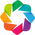

:Layout
   .Overlay.I    :Overlay
      .Curve.I   :Curve   [Roky]   (Hrubá míra reprodukce)
      .Scatter.I :Scatter   [Roky]   (Hrubá míra reprodukce)
   .Overlay.II   :Overlay
      .Curve.I   :Curve   [Roky]   (Naděje dožití mužů)
      .Scatter.I :Scatter   [Roky]   (Naděje dožití mužů)
   .Overlay.III  :Overlay
      .Curve.I   :Curve   [Roky]   (Naděje dožití žen)
      .Scatter.I :Scatter   [Roky]   (Naděje dožití žen)
   .Overlay.IV   :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrná délka trvání manželství při rozvodu)
      .Scatter.I :Scatter   [Roky]   (Průměrná délka trvání manželství při rozvodu)
   .Overlay.V    :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk matek při narození 1. dítěte)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk matek při narození 1. dítěte)
   .Overlay.VI   :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk matek při narození dítěte)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk matek při narození dítěte)
   .Overlay.VII  :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk mužů při prvním sňatku)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk mužů při prvním sňatku)
   .Overlay.VIII :Overlay
      .Curve.I   :Curve   [Roky]   (Průměrný věk žen při prvním sňatku)
      .Scatter.I :Scatter   [Roky]   (Průměrný věk žen při prvním sňatku)
   .Overlay.IX   :Overlay
      .Curve.I   :Curve   [Roky]   (Tabulková prvosňatečnost mužů (%))
      .Scatter.I :Scatter   [Roky]   (Tabulková prvosňatečnost mužů (%))
   .Overlay.X    :Overlay
      .Curve.I   :Curve   [Roky]   (Tabulková prvosňatečnost žen (%))
      .Scatter.I :Scatter   [Roky]   (Tabulková prvosňatečnost žen (%))
   .Overlay.XI   :Overlay
      .Curve.I   :Curve   [Roky]   (Úhrnná plodnost)
      .Scatter.I :Scatter   [Roky]   (Úhrnná plodnost)
   .Overlay.XII  :Overlay
      .Curve.I   :Curve   [Roky]   (Úhrnná rozvodovost (%))
      .Scatter.I :Scatter   [Roky]   (Úhrnná rozvodovost (%))
   .Overlay.XIII :Overlay
      .Curve.I   :Curve   [Roky]   (Čistá míra reprodukce)
      .Scatter.I :Scatter   [Roky]   (Čistá míra reprodukce)

In [69]:
import holoviews as hv
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

hv.extension('bokeh')

class OutlierLab:
    """
    Automated Outlier Detection + Time-series plots for ALL numeric variables.
    """
    def __init__(self, df, time_col="Roky"):
        self.df = df.copy()
        self.time_col = time_col

        if self.time_col not in self.df.columns:
            raise ValueError(f"time_col='{self.time_col}' not found in df columns.")

        # Detect numeric columns, excluding time_col if it's numeric
        self.numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        if self.time_col in self.numeric_cols:
            self.numeric_cols.remove(self.time_col)

    def detect_outliers(self, contamination=0.05):
        iso = IsolationForest(contamination=contamination, random_state=42)

        temp_data = self.df[self.numeric_cols].fillna(self.df[self.numeric_cols].median())
        self.df["is_outlier"] = iso.fit_predict(temp_data)
        self.df["is_outlier"] = self.df["is_outlier"].map({1: "Inlier", -1: "Outlier"})
        return self.df

    def plot_all_timeseries(self, ncols=2, width=650, height=250, show_outliers=True):
        """
        One time-series per numeric variable.
        If show_outliers=True and detect_outliers() was run, overlays outlier points.
        """
        # Sort by time for proper lines
        dfp = self.df.sort_values(self.time_col).copy()

        plots = []
        for col in self.numeric_cols:
            line = hv.Curve(dfp, kdims=[self.time_col], vdims=[col]).opts(
                width=width,
                height=height,
                title=col,
                tools=["hover"],
                show_grid=False,
            )

            if show_outliers and "is_outlier" in dfp.columns:
                out_pts = dfp[dfp["is_outlier"] == "Outlier"]
                pts = hv.Scatter(out_pts, kdims=[self.time_col], vdims=[col]).opts(
                    size=6,
                    color="#FF3366",
                    marker="circle",
                    tools=["hover"],
                )
                plots.append(line * pts)
            else:
                plots.append(line)

        return hv.Layout(plots).cols(ncols)

# --- Usage Example ---
lab = OutlierLab(df, time_col="Roky")
lab.detect_outliers(contamination=0.04)   # optional
lab.plot_all_timeseries(ncols=2)

Scaling, Norm and transformation

In [75]:
class FeatureTransformer:
    """
    Ultimate ML Pipeline: Section 3 (Final) - Preprocessing Suite
    Now supports 'Passthrough' columns that skip scaling (e.g., Years, IDs).
    """
    def __init__(self, df, target_col=None, skip_scaling_cols=None):
        self.df = df.copy()
        self.target_col = target_col
        self.skip_cols = skip_scaling_cols if skip_scaling_cols else []
        
        # 1. Detect all numeric and categorical
        all_numeric = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_features = self.df.select_dtypes(exclude=[np.number]).columns.tolist()
        
        # 2. Filter Lists
        self.numeric_features = []
        self.passthrough_features = []

        for col in all_numeric:
            # Skip targets and metadata
            if col == target_col or col == 'is_outlier':
                continue
            
            # Sort into 'Passthrough' or 'Scale' buckets
            if col in self.skip_cols:
                self.passthrough_features.append(col)
            else:
                self.numeric_features.append(col)

        # Remove skip_cols from categorical if they accidentally ended up there
        for col in self.skip_cols:
            if col in self.categorical_features:
                self.categorical_features.remove(col)

    def build_processor(self, use_knn_imputer=False, scaling_type='robust'):
        # Lane 1: Numeric (Impute + Scale)
        num_imputer = KNNImputer(n_neighbors=5) if use_knn_imputer else SimpleImputer(strategy='median')
        scaler = RobustScaler() if scaling_type == 'robust' else StandardScaler()
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', num_imputer),
            ('scaler', scaler)
        ])

        # Lane 2: Categorical (Impute + Encode)
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # Lane 3: Passthrough (Do Nothing)
        # We don't need a pipeline here, 'passthrough' keyword handles it.

        transformers_list = [
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('pass', 'passthrough', self.passthrough_features)
        ]

        self.processor = ColumnTransformer(transformers=transformers_list)
        return self.processor

    def fit_transform(self, drop_outliers=False):
        working_df = self.df.copy()

        # Outlier Logic
        if drop_outliers and 'is_outlier' in working_df.columns:
            working_df = working_df[working_df['is_outlier'] == 'Inlier'].copy()
        
        # Handle Target
        y = working_df[self.target_col] if self.target_col else None
        
        # Fit & Transform
        processed_data = self.processor.fit_transform(working_df)
        
        # --- SAFE NAME RECOVERY ---
        final_cols = []
        
        # 1. Numeric names (Scaled)
        final_cols += self.numeric_features
        
        # 2. Categorical names (Encoded) - check if empty first
        if len(self.categorical_features) > 0:
            cat_names = self.processor.named_transformers_['cat'].get_feature_names_out(self.categorical_features)
            final_cols += list(cat_names)
            
        # 3. Passthrough names (Unchanged)
        final_cols += self.passthrough_features
        
        clean_df = pd.DataFrame(processed_data, columns=final_cols)
        
        return clean_df, y

# --- Usage Example ---
transformer = FeatureTransformer(df, target_col='Úhrnná plodnost', skip_scaling_cols=['Roky'])
transformer.build_processor(scaling_type='robust')
scaled_df, y = transformer.fit_transform(drop_outliers=False)

transformer_t = FeatureTransformer(test_df, target_col='Úhrnná plodnost', skip_scaling_cols=['Roky'])
transformer_t.build_processor(scaling_type='robust')
scaled_test_df, y = transformer_t.fit_transform(drop_outliers=False)

scaled_df.head()

,Hrubá míra reprodukce,Naděje dožití mužů,Naděje dožití žen,Průměrná délka trvání manželství při rozvodu,Průměrný věk matek při narození 1. dítěte,Průměrný věk matek při narození dítěte,Průměrný věk mužů při prvním sňatku,Průměrný věk žen při prvním sňatku,Tabulková prvosňatečnost mužů (%),Tabulková prvosňatečnost žen (%),Úhrnná rozvodovost (%),Čistá míra reprodukce,Roky
0,1.450288,-1.733332,-1.647702,3.319690,0.0,1.203556,0.0,0.0,0.0,0.0,-0.794739,0.764604,1920.0
1,1.575622,-1.575344,-1.502381,1.492029,0.0,1.093434,0.0,0.0,0.0,0.0,-0.698460,0.877045,1921.0
2,1.303469,-1.507877,-1.440684,1.423725,0.0,1.069501,0.0,0.0,0.0,0.0,-0.665112,0.648414,1922.0
3,1.120840,-1.217653,-1.216710,1.688592,0.0,1.032991,0.0,0.0,0.0,0.0,-0.743018,0.494743,1923.0
4,0.830782,-1.241340,-1.218046,1.851581,0.0,1.014396,0.0,0.0,0.0,0.0,-0.762897,0.251120,1924.0


In [71]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

# Sklearn Core
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

# External Giants (with safety checks)
try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None
try:
    from lightgbm import LGBMRegressor
except ImportError:
    LGBMRegressor = None
try:
    from catboost import CatBoostRegressor
except ImportError:
    CatBoostRegressor = None

# Suppress convergence warnings for cleaner output
warnings.filterwarnings('ignore')

class ModelArena:
    """
    Ultimate ML Pipeline: Section 4 - The 'All-Stars' Model Zoo.
    Benchmarks regular ML models and Time-Series optimized Regressors.
    """
    def __init__(self, df, target_col, time_col=None):
        self.df = df.copy()
        self.target_col = target_col
        self.time_col = time_col
        self.results = []
        
        # Sort by time if applicable
        if self.time_col and self.time_col in self.df.columns:
            self.df = self.df.sort_values(by=self.time_col)
            print(f"⏳ Temporal Mode: Data sorted by '{self.time_col}'.")
        else:
            print("🎲 Standard Mode: Data will be shuffled.")

    def _create_lags(self, df, lags=[1, 2, 3]):
        """
        Engineers Lag Features (t-1, t-2, t-3) to allow ML models to 'see' history.
        """
        df_lagged = df.copy()
        for lag in lags:
            df_lagged[f'target_lag_{lag}'] = df_lagged[self.target_col].shift(lag)
        return df_lagged.dropna()

    def _get_model_zoo(self):
        """Returns a dictionary of all available models."""
        zoo = {
            # --- Baselines ---
            "Baseline (Mean)": DummyRegressor(strategy="mean"),
            
            # --- Linear Family ---
            "Linear Regression": LinearRegression(),
            "Ridge (L2)": Ridge(),
            "Lasso (L1)": Lasso(),
            "ElasticNet": ElasticNet(),
            "Huber (Robust)": HuberRegressor(), # Great for outliers
            
            # --- Support Vector & Neighbors ---
            "SVR (RBF)": SVR(kernel='rbf'),
            "KNN (Distance)": KNeighborsRegressor(n_neighbors=5),
            
            # --- Tree Ensembles ---
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
            
            # --- Boosting ---
            "AdaBoost": AdaBoostRegressor(random_state=42),
            "Gradient Boosting": GradientBoostingRegressor(random_state=42),
            "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=42) # Faster sklearn GBM
        }
        
        # Add External Libraries if installed
        if XGBRegressor:
            zoo["XGBoost"] = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42, n_jobs=-1)
        if LGBMRegressor:
            zoo["LightGBM"] = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
        if CatBoostRegressor:
            zoo["CatBoost"] = CatBoostRegressor(iterations=100, learning_rate=0.05, random_seed=42, verbose=0, allow_writing_files=False)
            
        return zoo

    def run_tournament(self, n_splits=5):
        # 1. Prepare Data
        if self.time_col:
            # Add lags so models can learn temporal patterns
            data = self._create_lags(self.df)
            cv = TimeSeriesSplit(n_splits=n_splits)
            split_type = "Time Series Walk-Forward"
        else:
            data = self.df.copy()
            cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            split_type = "K-Fold Random"

        X = data.drop(columns=[self.target_col])
        if self.time_col and self.time_col in X.columns:
            X = X.drop(columns=[self.time_col])
        y = data[self.target_col]

        models = self._get_model_zoo()
        total_models = len(models)
        print(f"⚔️ Starting Tournament with {total_models} models using {split_type}...")

        for i, (name, model) in enumerate(models.items()):
            # Using negative MAE because sklearn cross_validate expects 'higher is better'
            scores = cross_validate(
                model, X, y, cv=cv, 
                scoring=['neg_mean_absolute_error', 'r2'],
                n_jobs=-1  # Parallel processing for speed
            )
            
            # Record results per fold
            for fold_idx in range(n_splits):
                self.results.append({
                    "Model": name,
                    "Fold": fold_idx + 1,
                    "MAE": -scores['test_neg_mean_absolute_error'][fold_idx],
                    "R2": scores['test_r2'][fold_idx],
                    "Split Strategy": split_type
                })
            
            print(f"   [{i+1}/{total_models}] {name} completed.")

        self.results_df = pd.DataFrame(self.results)
        return self.results_df

    def plot_leaderboard(self):
        if not self.results: return "No results."
        
        # Calculate median MAE for sorting the plot
        order = self.results_df.groupby("Model")["MAE"].median().sort_values().index
        
        fig = px.box(
            self.results_df, 
            x="MAE", y="Model", color="Model", 
            points="all",
            category_orders={"Model": order}, # Best models at top
            title=f"🏆 Ultimate Model Leaderboard ({self.results_df['Split Strategy'].iloc[0]})",
            template="plotly_dark",
            color_discrete_sequence=px.colors.qualitative.Prism
        )
        fig.update_layout(
            xaxis_title="Mean Absolute Error (Lower is Better)", 
            yaxis_title=None, 
            showlegend=False, 
            height=600
        )
        return fig

# --- Usage Example ---
target_variable = 'Čistá míra reprodukce'
arena = ModelArena(scaled_df, target_col=target_variable, time_col='Roky')
results = arena.run_tournament()
arena.plot_leaderboard().show()

⏳ Temporal Mode: Data sorted by 'Roky'.
⚔️ Starting Tournament with 14 models using Time Series Walk-Forward...
   [1/14] Baseline (Mean) completed.
   [2/14] Linear Regression completed.
   [3/14] Ridge (L2) completed.
   [4/14] Lasso (L1) completed.
   [5/14] ElasticNet completed.
   [6/14] Huber (Robust) completed.
   [7/14] SVR (RBF) completed.
   [8/14] KNN (Distance) completed.
   [9/14] Random Forest completed.
   [10/14] Extra Trees completed.
   [11/14] AdaBoost completed.
   [12/14] Gradient Boosting completed.
   [13/14] Hist Gradient Boosting completed.
   [14/14] XGBoost completed.


In [72]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Silence Optuna's extensive logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

class HyperTuner:
    """
    Ultimate ML Pipeline: Section 5 - Bayesian Hyperparameter Optimization.
    Uses Optuna to surgically find the best parameters for the winning model.
    """
    def __init__(self, df, target_col, time_col=None):
        self.df = df.copy()
        self.target_col = target_col
        self.time_col = time_col
        self.best_model = None
        self.best_params = {}
        
        # Prepare Data (Lags & Sort)
        if self.time_col:
            self.df = self.df.sort_values(by=self.time_col)
            self.data = self._create_lags(self.df)
            self.cv = TimeSeriesSplit(n_splits=5)
            print("⏳ Tuning Mode: Time-Series Split (Walk-Forward)")
        else:
            self.data = self.df.copy()
            self.cv = KFold(n_splits=5, shuffle=True, random_state=42)
            print("🎲 Tuning Mode: Standard K-Fold")

        self.X = self.data.drop(columns=[self.target_col])
        if self.time_col and self.time_col in self.X.columns:
            self.X = self.X.drop(columns=[self.time_col])
        self.y = self.data[self.target_col]

    def _create_lags(self, df, lags=[1, 2, 3]):
        df_lagged = df.copy()
        for lag in lags:
            df_lagged[f'target_lag_{lag}'] = df_lagged[self.target_col].shift(lag)
        return df_lagged.dropna()

    def _get_search_space(self, trial, model_name):
        """
        Universal Search Space Registry.
        Automatically defines the grid based on the model name.
        """
        if "XGBoost" in model_name:
            return {
                "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
                "n_jobs": -1,
                "random_state": 42
            }
        
        elif "Random Forest" in model_name:
            return {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 5, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 15),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
                "random_state": 42
            }
        
        elif "ElasticNet" in model_name:
            return {
                "alpha": trial.suggest_float("alpha", 0.01, 10.0, log=True),
                "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
                "random_state": 42
            }
            
        else:
            raise ValueError(f"Model '{model_name}' is not yet registered in the Search Space.")

    def optimize(self, model_name, n_trials=20):
        """
        Runs the Bayesian Optimization loop.
        """
        print(f"🎯 Optimizing {model_name} with {n_trials} trials...")
        
        def objective(trial):
            # 1. Get Params
            params = self._get_search_space(trial, model_name)
            
            # 2. Instantiate Model
            if "XGBoost" in model_name:
                from xgboost import XGBRegressor
                model = XGBRegressor(**params)
            elif "Random Forest" in model_name:
                from sklearn.ensemble import RandomForestRegressor
                model = RandomForestRegressor(**params)
            elif "ElasticNet" in model_name:
                from sklearn.linear_model import ElasticNet
                model = ElasticNet(**params)
            
            # 3. Cross-Validate (using MAE)
            # We minimize MAE, so we flip the sign of the negative_mae score
            scores = cross_val_score(model, self.X, self.y, cv=self.cv, scoring='neg_mean_absolute_error', n_jobs=-1)
            mae = -scores.mean()
            
            return mae

        # Create Study
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)
        
        self.best_params = study.best_params
        print(f"✅ Optimization Complete. Best MAE: {study.best_value:.4f}")
        print(f"Best Params: {self.best_params}")
        
        return study

    def visualize_tuning(self, study):
        """
        Generates modern Plotly visualizations for the tuning process.
        """
        # 1. Optimization History (Are we improving?)
        fig_history = plot_optimization_history(study)
        fig_history.update_layout(title="Tuning History: Convergence Plot", template="plotly_dark")
        
        # 2. Hyperparameter Importance (What actually matters?)
        fig_importance = plot_param_importances(study)
        fig_importance.update_layout(title="Hyperparameter Importance: What drove the score?", template="plotly_dark")
        
        return fig_history, fig_importance

# --- Usage Example ---
tuner = HyperTuner(scaled_df, target_col=target_variable, time_col='Roky')
study = tuner.optimize("XGBoost", n_trials=15)
fig1, fig2 = tuner.visualize_tuning(study)
fig1.show()
fig2.show()

⏳ Tuning Mode: Time-Series Split (Walk-Forward)
🎯 Optimizing XGBoost with 15 trials...
✅ Optimization Complete. Best MAE: 0.3465
Best Params: {'n_estimators': 985, 'learning_rate': 0.013061349808293253, 'max_depth': 6, 'subsample': 0.7049184848863064, 'colsample_bytree': 0.7424934204487317, 'reg_alpha': 3.129430969537728e-06, 'reg_lambda': 5.355691912056411e-06}


In [73]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Silence Optuna's extensive logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

class HyperTuner:
    """
    Ultimate ML Pipeline: Section 5 - Bayesian Hyperparameter Optimization.
    Uses Optuna to fine-tune the champion model from the tournament.
    """
    def __init__(self, df, target_col, time_col=None):
        self.df = df.copy()
        self.target_col = target_col
        self.time_col = time_col
        self.best_params = {}
        
        # 1. Prepare Data (Lags & Sort)
        if self.time_col:
            self.df = self.df.sort_values(by=self.time_col)
            self.data = self._create_lags(self.df)
            self.cv = TimeSeriesSplit(n_splits=5)
            print("⏳ Tuning Mode: Time-Series Walk-Forward Validation")
        else:
            self.data = self.df.copy()
            self.cv = KFold(n_splits=5, shuffle=True, random_state=42)
            print("🎲 Tuning Mode: Standard K-Fold")

        self.X = self.data.drop(columns=[self.target_col])
        if self.time_col and self.time_col in self.X.columns:
            self.X = self.X.drop(columns=[self.time_col])
        self.y = self.data[self.target_col]

    def _create_lags(self, df, lags=[1, 2, 3]):
        df_lagged = df.copy()
        for lag in lags:
            df_lagged[f'target_lag_{lag}'] = df_lagged[self.target_col].shift(lag)
        return df_lagged.dropna()

    def _get_search_space(self, trial, model_name):
        """
        Universal Search Space Registry.
        Defines the hyperparameter grid based on the model name.
        """
        # --- LINEAR MODELS ---
        if "Ridge" in model_name:
            return {
                # Alpha is the regularization strength. 
                # Log scale allows us to search 0.001 and 100 with equal priority.
                "alpha": trial.suggest_float("alpha", 1e-4, 100.0, log=True),
                "solver": trial.suggest_categorical("solver", ['auto', 'svd', 'cholesky', 'lsqr'])
            }
        
        elif "Lasso" in model_name:
            return {
                "alpha": trial.suggest_float("alpha", 1e-4, 100.0, log=True),
                "selection": trial.suggest_categorical("selection", ['cyclic', 'random'])
            }

        elif "ElasticNet" in model_name:
            return {
                "alpha": trial.suggest_float("alpha", 1e-4, 100.0, log=True),
                "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0)
            }

        # --- TREE MODELS ---
        elif "XGBoost" in model_name:
            return {
                "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
            }
        
        elif "Random Forest" in model_name:
            return {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 5, 30),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 15),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
            }
            
        else:
            raise ValueError(f"🚨 Model '{model_name}' is not in the HyperTuner registry yet.")

    def optimize(self, model_name, n_trials=30):
        print(f"🎯 Optimizing {model_name} with {n_trials} trials...")
        
        def objective(trial):
            params = self._get_search_space(trial, model_name)
            
            # Instantiate the correct model dynamically
            if "Ridge" in model_name: model = Ridge(**params)
            elif "Lasso" in model_name: model = Lasso(**params)
            elif "ElasticNet" in model_name: model = ElasticNet(**params)
            elif "XGBoost" in model_name: model = XGBRegressor(**params, n_jobs=-1, random_state=42)
            elif "Random Forest" in model_name: model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
            
            # Cross Validate
            scores = cross_val_score(
                model, self.X, self.y, cv=self.cv, 
                scoring='neg_mean_absolute_error', n_jobs=-1
            )
            return -scores.mean() # Minimize MAE

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials)
        
        self.best_params = study.best_params
        print(f"✅ Best MAE: {study.best_value:.5f}")
        print(f"✅ Best Params: {self.best_params}")
        
        return study

    def visualize_tuning(self, study):
        """Generates Optuna's native interactive plots."""
        # 1. History: Did we converge?
        fig_hist = plot_optimization_history(study)
        fig_hist.update_layout(title="Tuning Convergence", template="plotly_dark", height=400)
        
        # 2. Importance: Which parameter mattered most?
        fig_imp = plot_param_importances(study)
        fig_imp.update_layout(title="Hyperparameter Importance", template="plotly_dark", height=400)
        
        return fig_hist, fig_imp

# --- Usage Example for your Winner ---
tuner = HyperTuner(scaled_df, target_col=target_variable, time_col='Roky')

# # Since Ridge (L2) won your tournament, we tune that specifically:
study = tuner.optimize("Ridge", n_trials=50)

# # Visualize
fig1, fig2 = tuner.visualize_tuning(study)
fig1.show()
fig2.show()

⏳ Tuning Mode: Time-Series Walk-Forward Validation
🎯 Optimizing Ridge with 50 trials...
✅ Best MAE: 0.16213
✅ Best Params: {'alpha': 0.019094488591678317, 'solver': 'auto'}


Section 6: Final Evaluation & Interpretation (The "Black Box" Opener)

⏳ Time Split: Training on first 14 rows, Testing on last 4 rows.
✅ Final Model Trained.

📊 TEST SET RESULTS:
MAE: 0.1579
RMSE: 0.1595
R2: 0.9569


🧠 SHAP Feature Importance (Beeswarm):


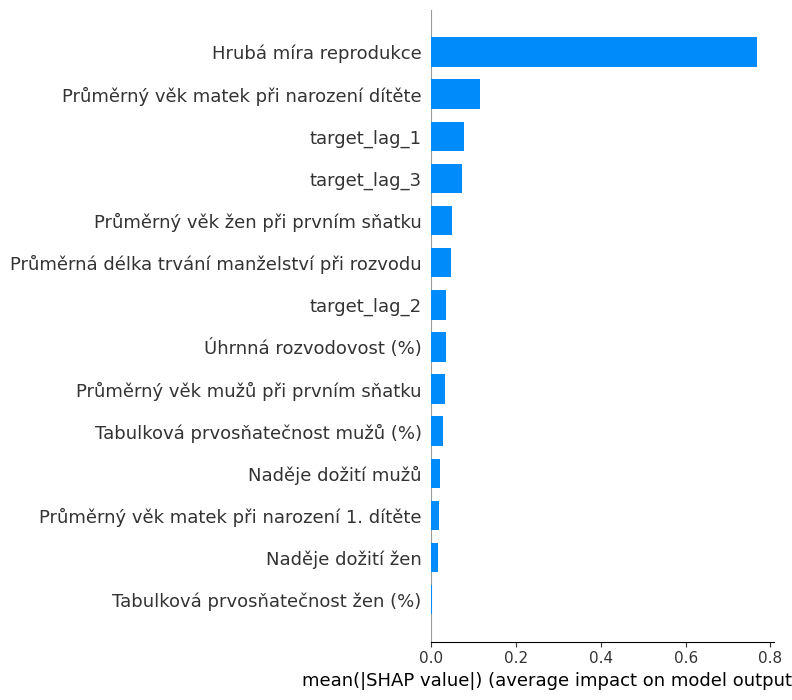

In [76]:
import shap
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Initialize JS for SHAP plots if running in notebook
shap.initjs()

class ModelInterpreter:
    """
    Ultimate ML Pipeline: Section 6 - Evaluation & Interpretation.
    Trains the final model, evaluates on a hold-out set, and explains predictions using SHAP.
    """
    def __init__(self, df, target_col, time_col=None, model_name="Ridge", best_params=None):
        self.df = df.copy()
        self.target_col = target_col
        self.time_col = time_col
        self.model_name = model_name
        self.params = best_params if best_params else {}
        self.model = None
        self.X_train, self.X_test = None, None
        self.y_train, self.y_test = None, None

    def _create_lags(self, df, lags=[1, 2, 3]):
        df_lagged = df.copy()
        for lag in lags:
            df_lagged[f'target_lag_{lag}'] = df_lagged[self.target_col].shift(lag)
        return df_lagged.dropna()

    def train_test_split(self, test_size=0.2):
        """
        Universal Splitter: Respects Time if time_col exists, otherwise random shuffle.
        """
        # 1. Feature Engineering (Lags)
        if self.time_col:
            self.df = self.df.sort_values(by=self.time_col)
            data = self._create_lags(self.df)
            
            # Time-based split (Cut off the last 20% as "The Future")
            split_idx = int(len(data) * (1 - test_size))
            train_data = data.iloc[:split_idx]
            test_data = data.iloc[split_idx:]
            print(f"⏳ Time Split: Training on first {len(train_data)} rows, Testing on last {len(test_data)} rows.")
        else:
            data = self.df.copy()
            # Random split
            from sklearn.model_selection import train_test_split
            train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
            print(f"🎲 Random Split: {len(train_data)} Train, {len(test_data)} Test.")

        # 2. Separate X and y
        self.y_train = train_data[self.target_col]
        self.y_test = test_data[self.target_col]
        
        self.X_train = train_data.drop(columns=[self.target_col])
        self.X_test = test_data.drop(columns=[self.target_col])
        
        # Remove time column from features if it exists (we don't train on 'Year')
        if self.time_col:
            self.X_train = self.X_train.drop(columns=[self.time_col])
            self.X_test = self.X_test.drop(columns=[self.time_col])

    def fit_final_model(self):
        """Instantiates and trains the winner using best_params."""
        if "Ridge" in self.model_name: self.model = Ridge(**self.params)
        elif "Lasso" in self.model_name: self.model = Lasso(**self.params)
        elif "ElasticNet" in self.model_name: self.model = ElasticNet(**self.params)
        elif "XGBoost" in self.model_name: self.model = XGBRegressor(**self.params)
        elif "Random Forest" in self.model_name: self.model = RandomForestRegressor(**self.params)
        
        self.model.fit(self.X_train, self.y_train)
        print("✅ Final Model Trained.")

    def evaluate(self):
        """Calculates comprehensive metrics."""
        preds = self.model.predict(self.X_test)
        
        mae = mean_absolute_error(self.y_test, preds)
        rmse = np.sqrt(mean_squared_error(self.y_test, preds))
        r2 = r2_score(self.y_test, preds)
        
        print(f"\n📊 TEST SET RESULTS:\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2: {r2:.4f}")
        return preds

    def plot_forecast(self, preds):
        """
        Creates a 'Reality vs Prediction' plot. 
        If time-series, it shows the trend line. If not, it shows Actual vs Predicted scatter.
        """
        if self.time_col:
            # Reconstruct dates/years for the x-axis
            # We align the test index back to the original dataframe's time column
            test_indices = self.y_test.index
            time_values = self.df.loc[test_indices, self.time_col]
            
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=time_values, y=self.y_test, mode='lines+markers', name='Actual Data', line=dict(color='#00CC96')))
            fig.add_trace(go.Scatter(x=time_values, y=preds, mode='lines+markers', name='Model Prediction', line=dict(color='#AB63FA', dash='dot')))
            
            fig.update_layout(title="Forecast: Reality vs Model", xaxis_title=self.time_col, yaxis_title=self.target_col, template="plotly_dark")
        else:
            # Regression Scatter Plot
            fig = px.scatter(x=self.y_test, y=preds, labels={'x': 'Actual', 'y': 'Predicted'}, title="Accuracy: Actual vs Predicted", template="plotly_dark")
            fig.add_shape(type="line", x0=self.y_test.min(), y0=self.y_test.min(), x1=self.y_test.max(), y1=self.y_test.max(), line=dict(color="white", dash="dash"))
            
        return fig

    def explain_with_shap(self):
        """
        Universal Explainer: Uses SHAP to visualize feature importance.
        """
        # Select background data for SHAP (small sample to speed it up)
        background = self.X_train.sample(min(100, len(self.X_train)), random_state=42)
        
        # Linear models use LinearExplainer, Trees use TreeExplainer, others use KernelExplainer
        if any(x in self.model_name for x in ["Ridge", "Lasso", "ElasticNet", "Linear"]):
            explainer = shap.LinearExplainer(self.model, background)
        elif any(x in self.model_name for x in ["XGBoost", "Random Forest", "Tree"]):
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.KernelExplainer(self.model.predict, background)
            
        shap_values = explainer.shap_values(self.X_test)
        
        # Summary Plot (The famous beeswarm)
        print("🧠 SHAP Feature Importance (Beeswarm):")
        shap.summary_plot(shap_values, self.X_test, plot_type="bar")

# --- Usage Example ---
interpreter = ModelInterpreter(scaled_test_df, target_col=target_variable, time_col='Roky', model_name="Ridge", best_params=study.best_params)
interpreter.train_test_split()
interpreter.fit_final_model()
preds = interpreter.evaluate()
interpreter.plot_forecast(preds).show()
interpreter.explain_with_shap()